## Import Library

In [1]:
!pip install gdown

In [2]:
!pip install tensorflow

In [3]:
!pip install torch

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import math
import time
import tensorflow as tf
from keras import callbacks
from keras.optimizers import Adam
from keras.layers import Dense, Input, Dropout, Normalization, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from scipy import optimize
import torch
import torch.nn as nn
import torch.optim as optim

## Import Pre-processed Data

In [5]:
!mkdir -p content/data
# Download all files
file_ids = [
    '1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq',  # X_train
    '1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1',  # X_train_resampled
    '1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR',  # X_test
    '1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ',  # X_test_resampled
    '1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z',  # Y_train
    '1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf',  # Y_train_resampled
    '1-CUpVhcZ6-Qop7R9Z6Btb2gEf7f0XgGy'   # Y_test
]

file_paths = [
    'content/data/X_train.pkl',
    'content/data/X_train_resampled.pkl',
    'content/data/X_test.pkl',
    'content/data/X_test_resampled.pkl',
    'content/data/Y_train.pkl',
    'content/data/Y_train_resampled.pkl',
    'content/data/Y_test.pkl'
]
for file_id, file_path in zip(file_ids, file_paths):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq
To: /content/content/data/X_train.pkl
100%|██████████| 21.4M/21.4M [00:01<00:00, 15.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1
To: /content/content/data/X_train_resampled.pkl
100%|██████████| 18.7M/18.7M [00:00<00:00, 19.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR
To: /content/content/data/X_test.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 14.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ
To: /content/content/data/X_test_resampled.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 18.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z
To: /content/content/data/Y_train.pkl
100%|██████████| 2.79M/2.79M [00:00<00:00, 56.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf
To: /conten

In [6]:
# Không dùng đến các cột _scaled, mà sẽ đi chuẩn hóa ở phía dưới
X_train = pd.read_pickle('content/data/X_train.pkl')
X_train_resampled = pd.read_pickle('content/data/X_train_resampled.pkl')
X_test = pd.read_pickle('content/data/X_test.pkl')
X_test_resampled = pd.read_pickle('content/data/X_test_resampled.pkl')
y_train = pd.read_pickle('content/data/Y_train.pkl')
y_train_resampled = pd.read_pickle('content/data/Y_train_resampled.pkl')
y_test = pd.read_pickle('content/data/Y_test.pkl')

In [7]:
result_acc = []
result_recall = []
pred_time = []

## 1. Neural Network - Thư viện (Keras)

### 1.1 No resampled

In [8]:
# Khởi tạo model
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
# Khởi tạo thuật toán Adam và compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
## Sử dụng 2 callback: ModelCheckpoint, EarlyStopping
# ModelCheckpoint: lưu lại mô hình tốt nhất
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',  # theo dõi loss của tập kiểm tra
    save_best_only=True,  # lưu chỉ mô hình tốt nhất
    save_weights_only=False,  # Lưu cả mô hình, không chỉ trọng số
    mode='min',  # chọn mô hình với loss thấp nhất
    verbose=1
)
# Early stopping: dừng lại sau 10 bước nếu như loss không giảm
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=200,
    shuffle = True,
    callbacks=[checkpoint, early_stopping]
)
best_model = load_model('best_model.keras')
# Dự đoán trên dữ liệu kiểm tra
start_time = time.time()
y_pred = (best_model.predict(X_test) > 0.5).astype(int)
end_time = time.time()
predict_time = end_time - start_time
pred_time.append(predict_time)
# Đánh giá độ chính xác
acc = accuracy_score(y_test, y_pred)*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))
print("Time to predict: {:.4f}s".format(predict_time))

Epoch 1/200
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7743 - loss: 0.4634
Epoch 1: val_loss improved from inf to 0.34765, saving model to best_model.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - binary_accuracy: 0.7743 - loss: 0.4634 - val_binary_accuracy: 0.8491 - val_loss: 0.3477
Epoch 2/200
1144/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8402 - loss: 0.3658
Epoch 2: val_loss improved from 0.34765 to 0.34072, saving model to best_model.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - binary_accuracy: 0.8402 - loss: 0.3657 - val_binary_accuracy: 0.8531 - val_loss: 0.3407
Epoch 3/200
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8473 - loss: 0.3515
Epoch 3: val_loss improved from 0.34072 to 0.33556, saving model to best_model.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.8473 - loss: 0.3515 - val_binary_accuracy: 0.8553 - val_loss: 0.3356
Epoch 4/200
1150/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin

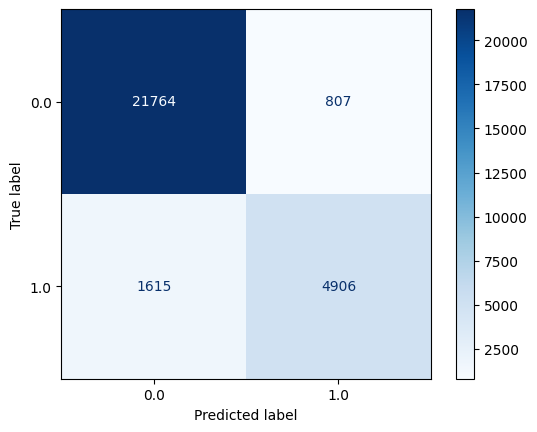

<Figure size 1200x1200 with 0 Axes>

In [9]:
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     22571
         1.0       0.86      0.75      0.80      6521

    accuracy                           0.92     29092
   macro avg       0.89      0.86      0.87     29092
weighted avg       0.91      0.92      0.91     29092



In [11]:
recall_s = recall_score(y_test, y_pred, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.7523385983744825
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9642461565725932


### 1.2 Resampled

In [12]:
# Huấn luyện mạng với optimizer và callbacks như trường hợp phía trên
# Khởi tạo resampled model
model_res = Sequential([
    Input(shape=[X_train_resampled.shape[1]]),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
# Khởi tạo thuật toán Adam và compile model
optimizer = Adam(learning_rate=0.0005)
model_res.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
## Sử dụng 2 callback: ModelCheckpoint, EarlyStopping
# ModelCheckpoint: lưu lại mô hình tốt nhất
checkpoint_res = ModelCheckpoint(
    'best_resampled_model.keras',
    monitor='val_loss',  # theo dõi loss của tập kiểm tra
    save_best_only=True,  # lưu chỉ mô hình tốt nhất
    save_weights_only=False,  # Lưu cả mô hình, không chỉ trọng số
    mode='min',  # chọn mô hình với loss thấp nhất
    verbose=1
)
# Early stopping: dừng lại sau 10 bước nếu như loss không giảm
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Model training
model_res.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test_resampled, y_test),
    batch_size=100,
    epochs=200,
    shuffle = True,
    callbacks=[checkpoint_res, early_stopping]
)
best_res_model = load_model('best_resampled_model.keras')
# Dự đoán trên dữ liệu kiểm tra
start_time = time.time()
y_pred_res = (best_res_model.predict(X_test_resampled) > 0.5).astype(int)
end_time = time.time()
predict_time = end_time - start_time
pred_time.append(predict_time)
# Đánh giá độ chính xác
acc = accuracy_score(y_test, y_pred_res)*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))
print("Time to predict: {:.4f}s".format(predict_time))

Epoch 1/200
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7757 - loss: 0.4725
Epoch 1: val_loss improved from inf to 0.39889, saving model to best_resampled_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - binary_accuracy: 0.7757 - loss: 0.4725 - val_binary_accuracy: 0.8192 - val_loss: 0.3989
Epoch 2/200
 998/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8033 - loss: 0.4236
Epoch 2: val_loss improved from 0.39889 to 0.38948, saving model to best_resampled_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8034 - loss: 0.4235 - val_binary_accuracy: 0.8261 - val_loss: 0.3895
Epoch 3/200
1011/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8107 - loss: 0.4130
Epoch 3: val_loss did not improve from 0.38948
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary_accuracy: 0.8108 - loss: 0.4129 - val_binary_accuracy: 0.8223 - val_loss: 0.3925
Epoch 4/200
1005/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.817

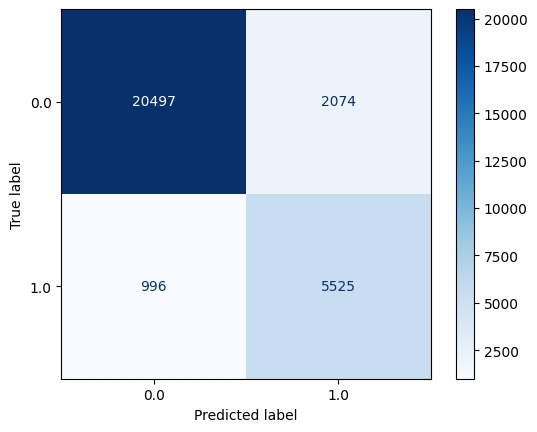

<Figure size 1200x1200 with 0 Axes>

In [13]:
cm=confusion_matrix(y_test,y_pred_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [14]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93     22571
         1.0       0.73      0.85      0.78      6521

    accuracy                           0.89     29092
   macro avg       0.84      0.88      0.86     29092
weighted avg       0.90      0.89      0.90     29092



In [15]:
recall_s = recall_score(y_test, y_pred_res, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.8472626897715074
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9081121793451774


## 2. Neural Network - Tự code (Sử dụng Pytorch)

In [16]:
# Xây dựng lớp mạng nơ-ron
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        # Các lớp: Linear, BatchNormalization (tùy chọn), ReLU, Dropout
        self.fc1 = nn.Linear(input_size, 128)  # Lớp đầu vào -> lớp ẩn đầu tiên (128 nodes)
        self.bn1 = nn.BatchNorm1d(128)         # Batch Normalization sau lớp ẩn đầu tiên
        self.fc2 = nn.Linear(128, 96)         # Lớp ẩn thứ 2 (96 nodes)
        self.bn2 = nn.BatchNorm1d(96)          # Batch Normalization sau lớp ẩn thứ 2
        self.fc3 = nn.Linear(96, 64)          # Lớp ẩn thứ 3 (64 nodes)
        self.fc4 = nn.Linear(64, 32)          # Lớp ẩn thứ 4 (32 nodes)
        self.fc5 = nn.Linear(32, 1)           # Lớp đầu ra (1 node cho phân loại nhị phân)

        # Hàm kích hoạt và dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)       # Dropout 30%

    def forward(self, x):
        # Áp dụng các lớp theo thứ tự
        x = self.relu(self.bn1(self.fc1(x)))  # Lớp 1: Linear -> BatchNorm -> ReLU
        x = self.dropout(x)                   # Áp dụng Dropout
        x = self.relu(self.bn2(self.fc2(x)))  # Lớp 2: Linear -> BatchNorm -> ReLU
        x = self.dropout(x)                   # Áp dụng Dropout
        x = self.relu(self.fc3(x))            # Lớp 3: Linear -> ReLU
        x = self.relu(self.fc4(x))            # Lớp 4: Linear -> ReLU
        x = torch.sigmoid(self.fc5(x))        # Lớp 5: Linear -> Sigmoid (đầu ra)
        return x

### 2.1 No resampled

In [17]:
# Chuyển đổi dữ liệu sang tensor (PyTorch yêu cầu dữ liệu dạng tensor)
X_train_np=X_train.to_numpy()
y_train_np=y_train.to_numpy()
X_test_np=X_test.to_numpy()
y_test_np=y_test.to_numpy()
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)  # reshape để khớp với output
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

In [18]:
# Khởi tạo mô hình
model = NeuralNetwork(input_size=X_train.shape[1])

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.BCELoss()  # Binary Cross Entropy Loss cho phân loại nhị phân
optimizer = optim.Adam(model.parameters(), lr=0.005)
gamma = 0.99  # Tỷ lệ giảm learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [19]:
# Huấn luyện mô hình
epochs = 300
for epoch in range(epochs):
    model.train()

    # Tiến hành tính toán dự đoán
    optimizer.zero_grad()  # Reset gradients
    outputs = model(X_train_tensor)

    # Tính toán loss và cập nhật gradient
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:  # In ra loss sau mỗi 10 epoch
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Dự đoán trên tập kiểm tra
model.eval()  # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm bộ nhớ
    start_time = time.time()
    y_pred_by_hand = model(X_test_tensor)
    y_pred_by_hand = (y_pred_by_hand > 0.5).float()  # Chuyển kết quả về 0 hoặc 1
    end_time = time.time()
    predict_time = end_time - start_time
    pred_time.append(predict_time)

# Đánh giá độ chính xác
acc = accuracy_score(y_test_tensor.numpy(), y_pred_by_hand.numpy())*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))
print("Time to predict: {:.4f}s".format(predict_time))

Epoch [10/300], Loss: 0.4037
Epoch [20/300], Loss: 0.3679
Epoch [30/300], Loss: 0.3548
Epoch [40/300], Loss: 0.3401
Epoch [50/300], Loss: 0.3329
Epoch [60/300], Loss: 0.3285
Epoch [70/300], Loss: 0.3249
Epoch [80/300], Loss: 0.3220
Epoch [90/300], Loss: 0.3175
Epoch [100/300], Loss: 0.3131
Epoch [110/300], Loss: 0.3100
Epoch [120/300], Loss: 0.3043
Epoch [130/300], Loss: 0.2992
Epoch [140/300], Loss: 0.2944
Epoch [150/300], Loss: 0.2877
Epoch [160/300], Loss: 0.2841
Epoch [170/300], Loss: 0.2786
Epoch [180/300], Loss: 0.2740
Epoch [190/300], Loss: 0.2689
Epoch [200/300], Loss: 0.2663
Epoch [210/300], Loss: 0.2626
Epoch [220/300], Loss: 0.2599
Epoch [230/300], Loss: 0.2570
Epoch [240/300], Loss: 0.2557
Epoch [250/300], Loss: 0.2542
Epoch [260/300], Loss: 0.2518
Epoch [270/300], Loss: 0.2501
Epoch [280/300], Loss: 0.2499
Epoch [290/300], Loss: 0.2486
Epoch [300/300], Loss: 0.2488
Test Accuracy 90.29%
Time to predict: 0.0429s


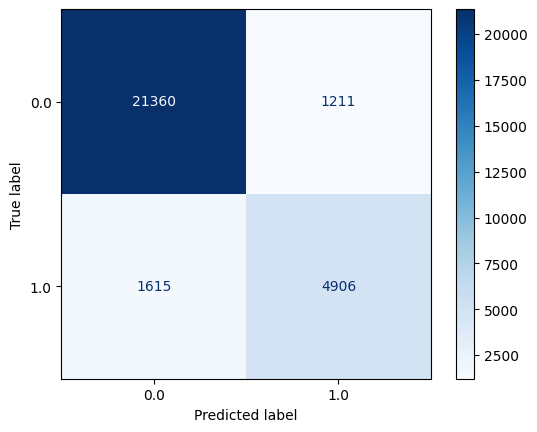

<Figure size 1200x1200 with 0 Axes>

In [20]:
cm=confusion_matrix(y_test_tensor.numpy(), y_pred_by_hand.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [21]:
print(classification_report(y_test_tensor.numpy(), y_pred_by_hand.numpy()))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     22571
         1.0       0.80      0.75      0.78      6521

    accuracy                           0.90     29092
   macro avg       0.87      0.85      0.86     29092
weighted avg       0.90      0.90      0.90     29092



In [22]:
recall_s = recall_score(y_test_tensor.numpy(), y_pred_by_hand.numpy(), average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.7523385983744825
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9463470825395419


### 2.2 Resampled

In [23]:
# Chuyển đổi dữ liệu sang tensor (PyTorch yêu cầu dữ liệu dạng tensor)
X_train_resampled_np=X_train_resampled.to_numpy()
y_train_resampled_np=y_train_resampled.to_numpy()
X_test_resampled_np=X_test_resampled.to_numpy()
X_train_resampled_tensor = torch.tensor(X_train_resampled_np, dtype=torch.float32)
y_train_resampled_tensor = torch.tensor(y_train_resampled_np, dtype=torch.float32).view(-1, 1)  # reshape để khớp với output
X_test_resampled_tensor = torch.tensor(X_test_resampled_np, dtype=torch.float32)

In [24]:
# Khởi tạo mô hình
model_res = NeuralNetwork(input_size=X_train_resampled.shape[1])

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.BCELoss()  # Binary Cross Entropy Loss cho phân loại nhị phân
optimizer = optim.Adam(model_res.parameters(), lr=0.005)
gamma = 0.99  # Tỷ lệ giảm learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [36]:
# Huấn luyện mô hình
epochs = 300
for epoch in range(epochs):
    model_res.train()

    # Tiến hành tính toán dự đoán
    optimizer.zero_grad()  # Reset gradients
    outputs = model_res(X_train_resampled_tensor)

    # Tính toán loss và cập nhật gradient
    loss = criterion(outputs, y_train_resampled_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:  # In ra loss sau mỗi 10 epoch
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Dự đoán trên tập kiểm tra
model_res.eval()  # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm bộ nhớ
    start_time = time.time()
    y_pred_res_by_hand = model_res(X_test_resampled_tensor)
    y_pred_res_by_hand = (y_pred_res_by_hand > 0.5).float()  # Chuyển kết quả về 0 hoặc 1
    end_time = time.time()
    predict_time = end_time - start_time
    pred_time.append(predict_time)

Epoch [10/300], Loss: 0.2892
Epoch [20/300], Loss: 0.2880
Epoch [30/300], Loss: 0.2873
Epoch [40/300], Loss: 0.2868
Epoch [50/300], Loss: 0.2859
Epoch [60/300], Loss: 0.2866
Epoch [70/300], Loss: 0.2850
Epoch [80/300], Loss: 0.2846
Epoch [90/300], Loss: 0.2847
Epoch [100/300], Loss: 0.2842
Epoch [110/300], Loss: 0.2845
Epoch [120/300], Loss: 0.2837
Epoch [130/300], Loss: 0.2834
Epoch [140/300], Loss: 0.2839
Epoch [150/300], Loss: 0.2838
Epoch [160/300], Loss: 0.2830
Epoch [170/300], Loss: 0.2826
Epoch [180/300], Loss: 0.2835
Epoch [190/300], Loss: 0.2825
Epoch [200/300], Loss: 0.2824
Epoch [210/300], Loss: 0.2830
Epoch [220/300], Loss: 0.2823
Epoch [230/300], Loss: 0.2831
Epoch [240/300], Loss: 0.2824
Epoch [250/300], Loss: 0.2823
Epoch [260/300], Loss: 0.2829
Epoch [270/300], Loss: 0.2816
Epoch [280/300], Loss: 0.2816
Epoch [290/300], Loss: 0.2827
Epoch [300/300], Loss: 0.2808


In [26]:
# Đánh giá độ chính xác
acc = accuracy_score(y_test_tensor.numpy(), y_pred_res_by_hand.numpy())*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 88.89%


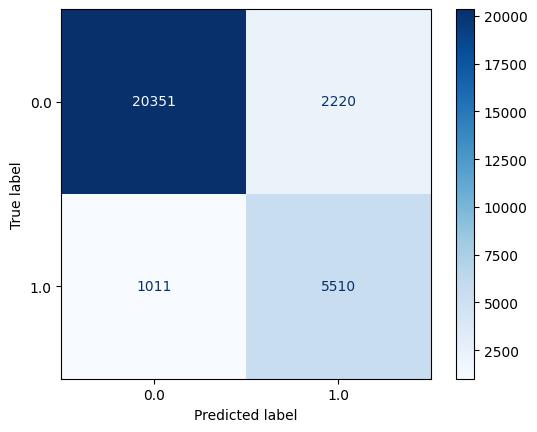

<Figure size 1200x1200 with 0 Axes>

In [27]:
cm=confusion_matrix(y_test_tensor.numpy(), y_pred_res_by_hand.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [28]:
print(classification_report(y_test_tensor.numpy(), y_pred_res_by_hand.numpy()))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93     22571
         1.0       0.71      0.84      0.77      6521

    accuracy                           0.89     29092
   macro avg       0.83      0.87      0.85     29092
weighted avg       0.90      0.89      0.89     29092



In [29]:
recall_s = recall_score(y_test_tensor.numpy(), y_pred_res_by_hand.numpy(), average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.8449624290752952
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9016437020956094


## 3. Model comparing

In [37]:
result_acc

[91.67468719923004, 89.44727072734773, 90.28598927540217, 88.89385398047574]

In [38]:
result_recall

[array([0.96424616, 0.7523386 ]),
 array([0.90811218, 0.84726269]),
 array([0.94634708, 0.7523386 ]),
 array([0.9016437 , 0.84496243])]

In [39]:
pred_time

[5.1686248779296875,
 2.036550283432007,
 0.04288530349731445,
 0.039671897888183594]

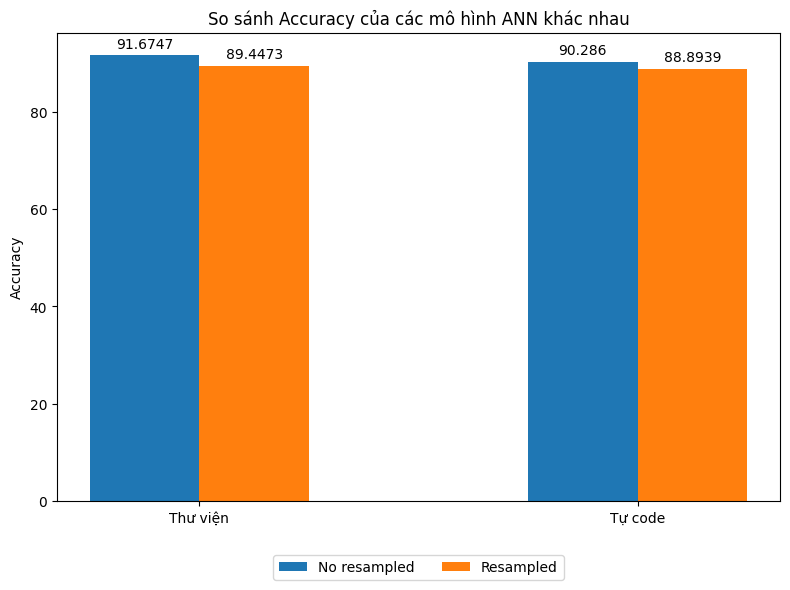

In [32]:
labels = ['Thư viện', 'Tự code']
no_res = [result_acc[0], result_acc[2]]
res = [result_acc[1], result_acc[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy của các mô hình ANN khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

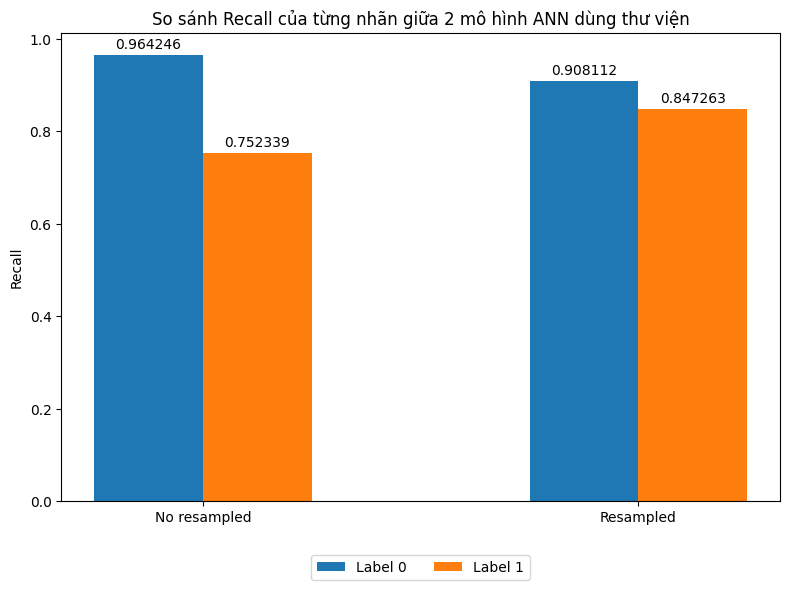

In [33]:
labels = ['No resampled', 'Resampled']
label_0 = [result_recall[0][0], result_recall[1][0]]
label_1 = [result_recall[0][1], result_recall[1][1]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, label_0, width, label='Label 0')
rects2 = ax.bar(x + width/2, label_1, width, label='Label 1')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('So sánh Recall của từng nhãn giữa 2 mô hình ANN dùng thư viện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

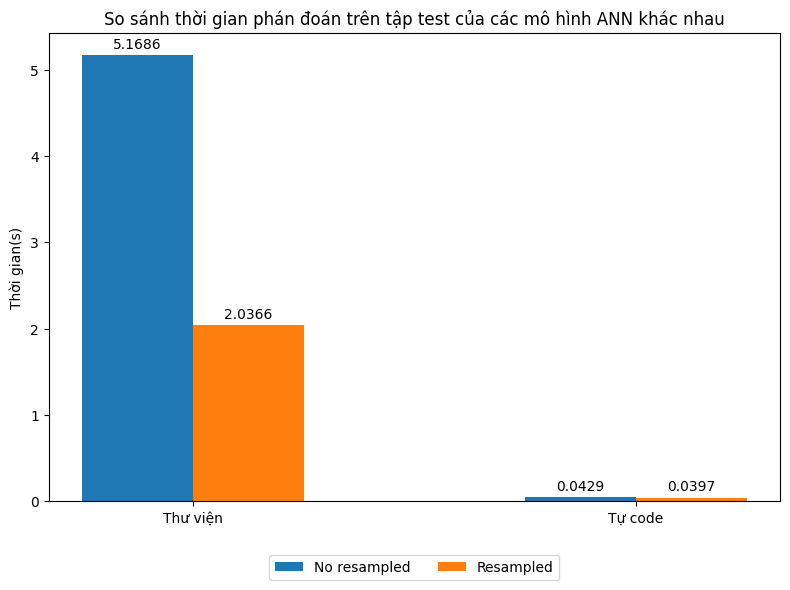

In [40]:
labels = ['Thư viện', 'Tự code']
no_res = [pred_time[0], pred_time[2]]
res = [pred_time[1], pred_time[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Thời gian(s)')
ax.set_title('So sánh thời gian phán đoán trên tập test của các mô hình ANN khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3, labels=[f"{value:.4f}" for value in no_res])
ax.bar_label(rects2, padding=3, labels=[f"{value:.4f}" for value in res])

fig.tight_layout()

plt.show()

In [41]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Result/Model_Evaluation/8. Neural Network.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([result_acc,result_recall,pred_time],f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
